In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from deep_translator import GoogleTranslator
from transformers import pipeline
import time
from pysentimiento.preprocessing import preprocess_tweet
from IPython.display import display

## Loading Raw Dataset

In [2]:
df = pd.read_csv("tweets-data/prabowo_24-04-2024_18-42-51.csv", delimiter=",")
df.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1770238273145000213,Tue Mar 19 23:57:48 +0000 2024,0,Update baru 32 propinsi DKI dominasi Prabowo G...,1770238273145000213,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu
1,1770238229121556916,Tue Mar 19 23:57:37 +0000 2024,0,Update baru 32 propinsi DKI dominasi Prabowo G...,1770238229121556916,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu
2,1770235600303727049,Tue Mar 19 23:57:35 +0000 2024,0,@Megatop99 @prabowo Gini ya contoh kasus pencu...,1770238220871344495,NaN,RadenTheoOFC,in,Isla-Milagrosa,0,2,0,https://twitter.com/RadenTheoOFC/status/177023...,1725727497579614208,RadenTheoOFC
3,1770238204236701803,Tue Mar 19 23:57:31 +0000 2024,0,Update baru 32 propinsi DKI dominasi Prabowo G...,1770238204236701803,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu
4,1770238178089423110,Tue Mar 19 23:57:25 +0000 2024,0,Update baru 32 propinsi DKI dominasi Prabowo G...,1770238178089423110,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu


In [5]:
len(df)

5014

In [4]:
df.nunique()

conversation_id_str        2823
created_at                 4844
favorite_count              120
full_text                  4795
id_str                     5014
image_url                   628
in_reply_to_screen_name    1050
lang                         29
location                    701
quote_count                  20
reply_count                  57
retweet_count                62
tweet_url                  5014
user_id_str                2460
username                   2460
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5014 entries, 0 to 5013
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   conversation_id_str      5014 non-null   int64 
 1   created_at               5014 non-null   object
 2   favorite_count           5014 non-null   int64 
 3   full_text                5014 non-null   object
 4   id_str                   5014 non-null   int64 
 5   image_url                1156 non-null   object
 6   in_reply_to_screen_name  3173 non-null   object
 7   lang                     5014 non-null   object
 8   location                 2358 non-null   object
 9   quote_count              5014 non-null   int64 
 10  reply_count              5014 non-null   int64 
 11  retweet_count            5014 non-null   int64 
 12  tweet_url                5014 non-null   object
 13  user_id_str              5014 non-null   int64 
 14  username                 5014 non-null  

In [8]:
# Checking duplicates
df.duplicated(subset=["full_text"]).sum()

219

In [9]:
df.drop_duplicates(subset=["full_text"], inplace=True)

In [10]:
# Checking duplicates
df.duplicated(subset=["full_text"]).sum()

0

## Common Tweet Cleaning (on progress)

- Language detection & filtering (only id)
- Links removal
- Turning emoji into emoji string representation (as it can contain sentiment values)

## Translating Text (Id -> En)

In [11]:
translator = GoogleTranslator(source="id", target="en")

In [30]:
len(df)

4795

In [25]:
translated_list = [] 
translate_success = False
for x in df["full_text"]:
    while not translate_success:
        try: 
            translate = translator.translate(x)
            translated_list.append(translate)
            translate_success = True
        except Exception as e:
            print("Error occured: ", e)
            time.sleep(1)
    translate_success = False

In [33]:
df.insert(4, "translated_text", translated_list)
df.head()

,conversation_id_str,created_at,favorite_count,full_text,translated_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1770238273145000213,Tue Mar 19 23:57:48 +0000 2024,0,Update baru 32 propinsi DKI dominasi Prabowo G...,New update for 32 DKI provinces dominated by P...,1770238273145000213,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu
2,1770235600303727049,Tue Mar 19 23:57:35 +0000 2024,0,@Megatop99 @prabowo Gini ya contoh kasus pencu...,@Megatop99 @prabowo Here's an example of a cas...,1770238220871344495,NaN,RadenTheoOFC,in,Isla-Milagrosa,0,2,0,https://twitter.com/RadenTheoOFC/status/177023...,1725727497579614208,RadenTheoOFC
6,1769660177320652966,Tue Mar 19 23:56:45 +0000 2024,0,@PutraPe24992947 @Dennysiregar7 @prabowo @naza...,@PutraPe24992947 @Dennysiregar7 @prabowo @naza...,1770238008534712823,NaN,PutraPe24992947,in,"Brussel, Belgia",0,1,0,https://twitter.com/H1m4_W4r1/status/177023800...,1379044492464943104,H1m4_W4r1
7,1769896257672380790,Tue Mar 19 23:56:16 +0000 2024,0,@ANDALASHUSNI Tps ku menang prabowo? Salam jw ...,@ANDALASHUSNI But can Prabowo win? Greetings m...,1770237885666767019,NaN,ANDALASHUSNI,in,NaN,0,0,0,https://twitter.com/Debot31086032/status/17702...,1440985120471613448,Debot31086032
8,1770013661173817536,Tue Mar 19 23:56:04 +0000 2024,0,@prabowo Petani yg d gusur kenapa tidak anda k...,@prabowo Farmers who have been evicted why don...,1770237837566480478,https://pbs.twimg.com/media/GJEl7lYaUAAqN8c.jpg,prabowo,in,NaN,0,0,0,https://twitter.com/Bakorsiliko15/status/17702...,1738205483230752768,Bakorsiliko15


In [35]:
df.to_csv("translated_prabowo.csv")

## Load translated dataset & applying tweet preprocessing (pysentiemento)

In [2]:
df = pd.read_csv("translated_prabowo.csv", delimiter=",")
df.head()

,Unnamed: 0,conversation_id_str,created_at,favorite_count,full_text,translated_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,0,1770238273145000213,Tue Mar 19 23:57:48 +0000 2024,0,Update baru 32 propinsi DKI dominasi Prabowo G...,New update for 32 DKI provinces dominated by P...,1770238273145000213,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu
1,2,1770235600303727049,Tue Mar 19 23:57:35 +0000 2024,0,@Megatop99 @prabowo Gini ya contoh kasus pencu...,@Megatop99 @prabowo Here's an example of a cas...,1770238220871344495,NaN,RadenTheoOFC,in,Isla-Milagrosa,0,2,0,https://twitter.com/RadenTheoOFC/status/177023...,1725727497579614208,RadenTheoOFC
2,6,1769660177320652966,Tue Mar 19 23:56:45 +0000 2024,0,@PutraPe24992947 @Dennysiregar7 @prabowo @naza...,@PutraPe24992947 @Dennysiregar7 @prabowo @naza...,1770238008534712823,NaN,PutraPe24992947,in,"Brussel, Belgia",0,1,0,https://twitter.com/H1m4_W4r1/status/177023800...,1379044492464943104,H1m4_W4r1
3,7,1769896257672380790,Tue Mar 19 23:56:16 +0000 2024,0,@ANDALASHUSNI Tps ku menang prabowo? Salam jw ...,@ANDALASHUSNI But can Prabowo win? Greetings m...,1770237885666767019,NaN,ANDALASHUSNI,in,NaN,0,0,0,https://twitter.com/Debot31086032/status/17702...,1440985120471613448,Debot31086032
4,8,1770013661173817536,Tue Mar 19 23:56:04 +0000 2024,0,@prabowo Petani yg d gusur kenapa tidak anda k...,@prabowo Farmers who have been evicted why don...,1770237837566480478,https://pbs.twimg.com/media/GJEl7lYaUAAqN8c.jpg,prabowo,in,NaN,0,0,0,https://twitter.com/Bakorsiliko15/status/17702...,1738205483230752768,Bakorsiliko15


In [5]:
df['preprocessed_text'] = df['translated_text'].apply(lambda x: preprocess_tweet(x, shorten=2, lang="en"))
df.head()

,Unnamed: 0,conversation_id_str,created_at,favorite_count,full_text,translated_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,preprocessed_text
0,0,1770238273145000213,Tue Mar 19 23:57:48 +0000 2024,0,Update baru 32 propinsi DKI dominasi Prabowo G...,New update for 32 DKI provinces dominated by P...,1770238273145000213,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu,New update for 32 DKI provinces dominated by P...
1,2,1770235600303727049,Tue Mar 19 23:57:35 +0000 2024,0,@Megatop99 @prabowo Gini ya contoh kasus pencu...,@Megatop99 @prabowo Here's an example of a cas...,1770238220871344495,NaN,RadenTheoOFC,in,Isla-Milagrosa,0,2,0,https://twitter.com/RadenTheoOFC/status/177023...,1725727497579614208,RadenTheoOFC,@USER @USER Here's an example of a case of kid...
2,6,1769660177320652966,Tue Mar 19 23:56:45 +0000 2024,0,@PutraPe24992947 @Dennysiregar7 @prabowo @naza...,@PutraPe24992947 @Dennysiregar7 @prabowo @naza...,1770238008534712823,NaN,PutraPe24992947,in,"Brussel, Belgia",0,1,0,https://twitter.com/H1m4_W4r1/status/177023800...,1379044492464943104,H1m4_W4r1,"@USER @USER @USER @USER Come on, let's watch i..."
3,7,1769896257672380790,Tue Mar 19 23:56:16 +0000 2024,0,@ANDALASHUSNI Tps ku menang prabowo? Salam jw ...,@ANDALASHUSNI But can Prabowo win? Greetings m...,1770237885666767019,NaN,ANDALASHUSNI,in,NaN,0,0,0,https://twitter.com/Debot31086032/status/17702...,1440985120471613448,Debot31086032,@USER But can Prabowo win? Greetings middle JW?
4,8,1770013661173817536,Tue Mar 19 23:56:04 +0000 2024,0,@prabowo Petani yg d gusur kenapa tidak anda k...,@prabowo Farmers who have been evicted why don...,1770237837566480478,https://pbs.twimg.com/media/GJEl7lYaUAAqN8c.jpg,prabowo,in,NaN,0,0,0,https://twitter.com/Bakorsiliko15/status/17702...,1738205483230752768,Bakorsiliko15,@USER Farmers who have been evicted why don't ...


In [6]:
df.duplicated(subset=["preprocessed_text"]).sum()

642

In [8]:
df.drop_duplicates(subset=["preprocessed_text"], inplace=True)

In [9]:
df.duplicated(subset=["preprocessed_text"]).sum()

0

In [41]:
len(df)

4153

## Labeling Process

In [28]:
pipe = pipeline("text-classification", model="finiteautomata/bertweet-base-emotion-analysis", tokenizer="finiteautomata/bertweet-base-emotion-analysis")

In [32]:
str_input = "A Highway Network is an architecture designed to ease gradient-based training of very deep networks. They allow unimpeded information flow across several layers on information highways. The architecture is characterized by the use of gating units which learn to regulate the flow of information through a network. A Highway Network is an architecture designed to ease gradient-based training of very deep networks. They allow unimpeded information flow across several layers on information highways. The architecture is characterized by the use of gating units which learn to regulate the flow of information through a network. A Highway Network is an architecture designed to ease gradient-based training of very deep networks. They allow unimpeded information flow across several layers on information highways. The architecture is characterized by the use of gating units which learn to regulate the flow of information through a network." * 4
len(str_input)

3764

In [36]:
pipe(str_input, truncation=True)[0]['label']

'others'

In [38]:
labels = []
for text in df["preprocessed_text"]:
    label = pipe(text, truncation=True)[0]['label']
    labels.append(label)

In [42]:
len(labels)

4153

In [49]:
df.insert(4, "label", labels)
df.head()

,Unnamed: 0,conversation_id_str,created_at,favorite_count,label,full_text,translated_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,preprocessed_text
0,0,1770238273145000213,Tue Mar 19 23:57:48 +0000 2024,0,anger,Update baru 32 propinsi DKI dominasi Prabowo G...,New update for 32 DKI provinces dominated by P...,1770238273145000213,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu,New update for 32 DKI provinces dominated by P...
1,2,1770235600303727049,Tue Mar 19 23:57:35 +0000 2024,0,others,@Megatop99 @prabowo Gini ya contoh kasus pencu...,@Megatop99 @prabowo Here's an example of a cas...,1770238220871344495,NaN,RadenTheoOFC,in,Isla-Milagrosa,0,2,0,https://twitter.com/RadenTheoOFC/status/177023...,1725727497579614208,RadenTheoOFC,@USER @USER Here's an example of a case of kid...
2,6,1769660177320652966,Tue Mar 19 23:56:45 +0000 2024,0,others,@PutraPe24992947 @Dennysiregar7 @prabowo @naza...,@PutraPe24992947 @Dennysiregar7 @prabowo @naza...,1770238008534712823,NaN,PutraPe24992947,in,"Brussel, Belgia",0,1,0,https://twitter.com/H1m4_W4r1/status/177023800...,1379044492464943104,H1m4_W4r1,"@USER @USER @USER @USER Come on, let's watch i..."
3,7,1769896257672380790,Tue Mar 19 23:56:16 +0000 2024,0,others,@ANDALASHUSNI Tps ku menang prabowo? Salam jw ...,@ANDALASHUSNI But can Prabowo win? Greetings m...,1770237885666767019,NaN,ANDALASHUSNI,in,NaN,0,0,0,https://twitter.com/Debot31086032/status/17702...,1440985120471613448,Debot31086032,@USER But can Prabowo win? Greetings middle JW?
4,8,1770013661173817536,Tue Mar 19 23:56:04 +0000 2024,0,disgust,@prabowo Petani yg d gusur kenapa tidak anda k...,@prabowo Farmers who have been evicted why don...,1770237837566480478,https://pbs.twimg.com/media/GJEl7lYaUAAqN8c.jpg,prabowo,in,NaN,0,0,0,https://twitter.com/Bakorsiliko15/status/17702...,1738205483230752768,Bakorsiliko15,@USER Farmers who have been evicted why don't ...


In [50]:
df['label'].value_counts()

label
others      2798
disgust      705
anger        273
joy          263
sadness       45
surprise      43
fear          26
Name: count, dtype: int64

In [51]:
df.to_csv("initial_labeled_prabowo.csv")

In [54]:
for x in df[df['label'] == 'fear']['full_text']:
    print(x)

@DrEvaChaniago @nobody_nonono88 Mengerika 🇮🇩 mulai Dikuasai China mrlalu Pengkhianat Bangsa Makzulkan jokowi perusak Demokrasi &amp; Pemilu jurdil ... Diskualifikasi Prabowo Gibran demi keutuhan 🇮🇩
@Maruahalsiahaa2 Gegara paksakan Prabowo Gibran harus menang pemilu 2024 memantik Demo massa di depan gedung DPR dan depan gedung KPU malam ini 19/3/2024 ngeriii bener. Smoga RI terhindar dari musibah terulang jaman presiden Soeharto mundur dari jabatan. Tidak benturkan demo rakyat dng aparat
@dekade_08 Buzzer Rp lagi galau ni yee ngetwit secara massive... khawatir gak ada transferan dari @prabowo @jokowi
@azharie27 @1HandeDelisii @jokowi @prabowo @gibran_tweet @budimuni98 @ImamWM @yosephrosario_ @Bangher1_ Hmmh mulai stres pendukung abah anies
@BANGSAygSUJUD @prabowo Ngeri x 4 diantaranya yang menggunakan standar ganda untuk membantah israel itu pelaku genosida macron orang yang melarang muslim menggunakan hijab di tempat terbuka biden sang diktator genosida di palestina shunak juga seorang

## Loading labeled dataset

In [5]:
df = pd.read_csv("initial_labeled_prabowo.csv", delimiter=",")
df.head()

,Unnamed: 0.1,Unnamed: 0,conversation_id_str,created_at,favorite_count,label,full_text,translated_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,preprocessed_text
0,0,0,1770238273145000213,Tue Mar 19 23:57:48 +0000 2024,0,anger,Update baru 32 propinsi DKI dominasi Prabowo G...,New update for 32 DKI provinces dominated by P...,1770238273145000213,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu,New update for 32 DKI provinces dominated by P...
1,1,2,1770235600303727049,Tue Mar 19 23:57:35 +0000 2024,0,others,@Megatop99 @prabowo Gini ya contoh kasus pencu...,@Megatop99 @prabowo Here's an example of a cas...,1770238220871344495,NaN,RadenTheoOFC,in,Isla-Milagrosa,0,2,0,https://twitter.com/RadenTheoOFC/status/177023...,1725727497579614208,RadenTheoOFC,@USER @USER Here's an example of a case of kid...
2,2,6,1769660177320652966,Tue Mar 19 23:56:45 +0000 2024,0,others,@PutraPe24992947 @Dennysiregar7 @prabowo @naza...,@PutraPe24992947 @Dennysiregar7 @prabowo @naza...,1770238008534712823,NaN,PutraPe24992947,in,"Brussel, Belgia",0,1,0,https://twitter.com/H1m4_W4r1/status/177023800...,1379044492464943104,H1m4_W4r1,"@USER @USER @USER @USER Come on, let's watch i..."
3,3,7,1769896257672380790,Tue Mar 19 23:56:16 +0000 2024,0,others,@ANDALASHUSNI Tps ku menang prabowo? Salam jw ...,@ANDALASHUSNI But can Prabowo win? Greetings m...,1770237885666767019,NaN,ANDALASHUSNI,in,NaN,0,0,0,https://twitter.com/Debot31086032/status/17702...,1440985120471613448,Debot31086032,@USER But can Prabowo win? Greetings middle JW?
4,4,8,1770013661173817536,Tue Mar 19 23:56:04 +0000 2024,0,disgust,@prabowo Petani yg d gusur kenapa tidak anda k...,@prabowo Farmers who have been evicted why don...,1770237837566480478,https://pbs.twimg.com/media/GJEl7lYaUAAqN8c.jpg,prabowo,in,NaN,0,0,0,https://twitter.com/Bakorsiliko15/status/17702...,1738205483230752768,Bakorsiliko15,@USER Farmers who have been evicted why don't ...


In [6]:
len(df)

4153

In [7]:
df['label'].value_counts()

label
others      2798
disgust      705
anger        273
joy          263
sadness       45
surprise      43
fear          26
Name: count, dtype: int64

In [12]:
df_temp = df[df['label'] == 'joy']
df_temp.to_json("json_prabowo.json", orient='records')

## Dataset Analysis

**Date range analysis (Top vs Latest)**

In [2]:
df_latest = pd.read_csv("tweets-data/prabowo_24-04-2024_18-42-51.csv", delimiter=",")
df_top = pd.read_csv("tweets-data/prabowo,_gibran,_paslon_02_24-04-2024_18-11-48.csv", delimiter=",")
display(df_top.head())
print("\n\n")
display(df_latest.head())

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1781990183640191400,Sun Apr 21 10:15:42 +0000 2024,5,wahhh keren banget karna dengan #96JutaRakyatB...,1781990183640191400,https://pbs.twimg.com/media/GLrmnV9agAAUUZA.jpg,NaN,in,NaN,0,2,3,https://twitter.com/nlakik/status/178199018364...,1094036502760239104,nlakik
1,1781543310718550277,Sat Apr 20 09:32:50 +0000 2024,8,@BANGSAygSUJUD @prabowo @gibran_tweet @Bara_Rc...,1781617007638827223,https://pbs.twimg.com/media/GLmTOF-b0AA6yA7.jpg,BANGSAygSUJUD,in,NaN,0,3,2,https://twitter.com/RIPDEMOKRASI/status/178161...,1603630153816367104,RIPDEMOKRASI
2,1780110881411723700,Tue Apr 16 05:48:01 +0000 2024,29,Kemaren sempat jadi tim Kampanyenya paslon 02 ...,1780110881411723700,NaN,NaN,in,Brunei,2,11,4,https://twitter.com/Amran_bin_Ali/status/17801...,1637094881633120256,Amran_bin_Ali
3,1782284447498351052,Mon Apr 22 05:45:00 +0000 2024,0,Kubu paslon 01 Anies Baswedan-Muhaimin Iskanda...,1782284447498351052,https://pbs.twimg.com/ext_tw_video_thumb/17822...,NaN,in,Indonesia,0,0,0,https://twitter.com/tribunnews/status/17822844...,124171593,tribunnews
4,1781990123879661817,Sun Apr 21 10:15:27 +0000 2024,12,banyak banget yg dukung sampe #96JutaRakyatBer...,1781990123879661817,https://pbs.twimg.com/media/GLrmkRMbEAAmX1r.jpg,NaN,in,NaN,0,2,15,https://twitter.com/copycawt/status/1781990123...,1054327412794699776,copycawt


,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1770238273145000213,Tue Mar 19 23:57:48 +0000 2024,0,Update baru 32 propinsi DKI dominasi Prabowo G...,1770238273145000213,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu
1,1770238229121556916,Tue Mar 19 23:57:37 +0000 2024,0,Update baru 32 propinsi DKI dominasi Prabowo G...,1770238229121556916,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu
2,1770235600303727049,Tue Mar 19 23:57:35 +0000 2024,0,@Megatop99 @prabowo Gini ya contoh kasus pencu...,1770238220871344495,NaN,RadenTheoOFC,in,Isla-Milagrosa,0,2,0,https://twitter.com/RadenTheoOFC/status/177023...,1725727497579614208,RadenTheoOFC
3,1770238204236701803,Tue Mar 19 23:57:31 +0000 2024,0,Update baru 32 propinsi DKI dominasi Prabowo G...,1770238204236701803,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu
4,1770238178089423110,Tue Mar 19 23:57:25 +0000 2024,0,Update baru 32 propinsi DKI dominasi Prabowo G...,1770238178089423110,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu


In [3]:
# Converting date 
df_latest['created_at'] = pd.to_datetime(df_latest['created_at'], format="%a %b %d %H:%M:%S %z %Y")
df_top['created_at'] = pd.to_datetime(df_top['created_at'], format="%a %b %d %H:%M:%S %z %Y")
df_latest.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1770238273145000213,2024-03-19 23:57:48+00:00,0,Update baru 32 propinsi DKI dominasi Prabowo G...,1770238273145000213,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu
1,1770238229121556916,2024-03-19 23:57:37+00:00,0,Update baru 32 propinsi DKI dominasi Prabowo G...,1770238229121556916,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu
2,1770235600303727049,2024-03-19 23:57:35+00:00,0,@Megatop99 @prabowo Gini ya contoh kasus pencu...,1770238220871344495,NaN,RadenTheoOFC,in,Isla-Milagrosa,0,2,0,https://twitter.com/RadenTheoOFC/status/177023...,1725727497579614208,RadenTheoOFC
3,1770238204236701803,2024-03-19 23:57:31+00:00,0,Update baru 32 propinsi DKI dominasi Prabowo G...,1770238204236701803,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu
4,1770238178089423110,2024-03-19 23:57:25+00:00,0,Update baru 32 propinsi DKI dominasi Prabowo G...,1770238178089423110,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu


In [4]:
df_latest_daily = df_latest.resample(rule='D', on='created_at').agg({
    "tweet_url":'nunique'
})
df_latest_daily.head()

,tweet_url
created_at,
2024-03-18 00:00:00+00:00,915
2024-03-19 00:00:00+00:00,4099


In [5]:
df_top_daily = df_top.resample(rule='D', on='created_at').agg({
    "tweet_url":'nunique'
})
df_top_daily

,tweet_url
created_at,
2024-04-16 00:00:00+00:00,6
2024-04-17 00:00:00+00:00,10
2024-04-18 00:00:00+00:00,10
2024-04-19 00:00:00+00:00,9
2024-04-20 00:00:00+00:00,9
2024-04-21 00:00:00+00:00,16
2024-04-22 00:00:00+00:00,25
2024-04-23 00:00:00+00:00,13
2024-04-24 00:00:00+00:00,4


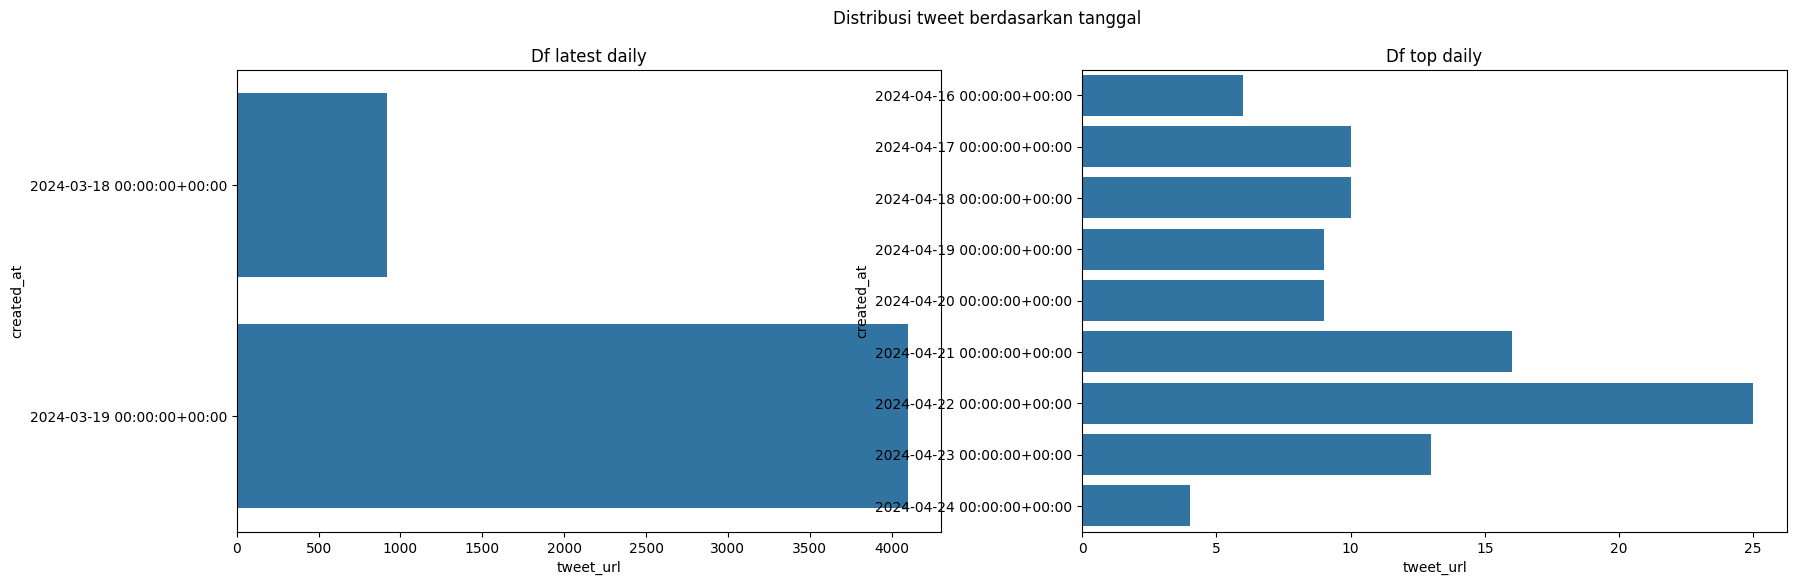

In [8]:
fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=2)

# First chart: df_latest_daily
sns.barplot(
    x='tweet_url',
    y='created_at',
    data=df_latest_daily,
    ax=axes[0]
)
axes[0].set_title("Df latest daily")

# First chart: df_top_daily
sns.barplot(
    x='tweet_url',
    y='created_at',
    data=df_top_daily,
    ax=axes[1]
)
axes[1].set_title("Df top daily")


plt.suptitle("Distribusi tweet berdasarkan tanggal")
plt.show()

**Checking the presence of emojis**

**Emotion Words Analysis (In the labeled data)**

In [ ]:
# Prolly remove common words, then use wordcloud.

In [9]:
df_labeled = pd.read_csv("initial_labeled_prabowo.csv", delimiter=",")
df_labeled.head()

,Unnamed: 0.1,Unnamed: 0,conversation_id_str,created_at,favorite_count,label,full_text,translated_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,preprocessed_text
0,0,0,1770238273145000213,Tue Mar 19 23:57:48 +0000 2024,0,anger,Update baru 32 propinsi DKI dominasi Prabowo G...,New update for 32 DKI provinces dominated by P...,1770238273145000213,NaN,NaN,in,Bogor - Jakarta,0,0,0,https://twitter.com/WismantoWahyu/status/17702...,1085177612,WismantoWahyu,New update for 32 DKI provinces dominated by P...
1,1,2,1770235600303727049,Tue Mar 19 23:57:35 +0000 2024,0,others,@Megatop99 @prabowo Gini ya contoh kasus pencu...,@Megatop99 @prabowo Here's an example of a cas...,1770238220871344495,NaN,RadenTheoOFC,in,Isla-Milagrosa,0,2,0,https://twitter.com/RadenTheoOFC/status/177023...,1725727497579614208,RadenTheoOFC,@USER @USER Here's an example of a case of kid...
2,2,6,1769660177320652966,Tue Mar 19 23:56:45 +0000 2024,0,others,@PutraPe24992947 @Dennysiregar7 @prabowo @naza...,@PutraPe24992947 @Dennysiregar7 @prabowo @naza...,1770238008534712823,NaN,PutraPe24992947,in,"Brussel, Belgia",0,1,0,https://twitter.com/H1m4_W4r1/status/177023800...,1379044492464943104,H1m4_W4r1,"@USER @USER @USER @USER Come on, let's watch i..."
3,3,7,1769896257672380790,Tue Mar 19 23:56:16 +0000 2024,0,others,@ANDALASHUSNI Tps ku menang prabowo? Salam jw ...,@ANDALASHUSNI But can Prabowo win? Greetings m...,1770237885666767019,NaN,ANDALASHUSNI,in,NaN,0,0,0,https://twitter.com/Debot31086032/status/17702...,1440985120471613448,Debot31086032,@USER But can Prabowo win? Greetings middle JW?
4,4,8,1770013661173817536,Tue Mar 19 23:56:04 +0000 2024,0,disgust,@prabowo Petani yg d gusur kenapa tidak anda k...,@prabowo Farmers who have been evicted why don...,1770237837566480478,https://pbs.twimg.com/media/GJEl7lYaUAAqN8c.jpg,prabowo,in,NaN,0,0,0,https://twitter.com/Bakorsiliko15/status/17702...,1738205483230752768,Bakorsiliko15,@USER Farmers who have been evicted why don't ...


In [10]:
df_labeled["label"].value_counts()

label
others      2798
disgust      705
anger        273
joy          263
sadness       45
surprise      43
fear          26
Name: count, dtype: int64

In [12]:
df_labeled[df_labeled["label"] == "fear"]["full_text"]

303     @DrEvaChaniago @nobody_nonono88 Mengerika 🇮🇩 m...
466     @Maruahalsiahaa2 Gegara paksakan Prabowo Gibra...
525     @dekade_08 Buzzer Rp lagi galau ni yee ngetwit...
540     @azharie27 @1HandeDelisii @jokowi @prabowo @gi...
689     @BANGSAygSUJUD @prabowo Ngeri x 4 diantaranya ...
728     @icihahaha Serem kak. Kmren saya naik pesawat ...
752     @HMJUSUFRIZAL @prabowo @KPU_ID Harus dipantau ...
945     #Tanda Alam yg kadang kita tdk menyadariNya......
1322         @Strategi_Bisnis Prabowo buku nya ngeri2 cuy
1389    Indonesia will announce the official results o...
1575    @Dennysiregar7 Mantab memang harus ada demo yg...
1699    @BANGSAygSUJUD @Kusmana30773963 @prabowo @gibr...
1714     @veraagustian_ @prabowo Generasi Indonesia Cemas
1877          @prabowo Kuwatir sakit setroke nya kambuh .
2091    *Rapat Pleno KPU Papua Masuk Hari ke 13 Situas...
2168    @tempodotco Bahaya bgt nanti jadi banyak yg ma...
2250    Artinya situasi saat Pak Prabowo yg kalah lbh ...
3060    Siap-s

In [13]:
print('"hello"')

"hello"
